In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig, Draw
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import gzip
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64

# AiZynthFinder outputs

In [145]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [22]:
from IPython.display import display_html
from itertools import cycle
def display_in_matrix_form(*args, titles = cycle(['']), rows, columns):
    for i in range(0, rows):
        html_str=''
        row_args = args[i*columns:(i+1)*columns]
        row_titles = titles[i*columns:(i+1)*columns]
        for j in range(0, columns):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2 style="text-align: center;">{row_titles[j]}</h2>'
            html_str+=row_args[j].to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)

In [136]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore','models', 'full_reaxys_model_1024bool','model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


# 1

In [146]:
data = pd.read_csv('data/7Msmiles500-0-default.csv')
data_par1 = pd.read_csv('data/7Msmiles500-0-par1.csv')

In [99]:
true = len(data[data.number_of_steps == 1])
true1 = len(data_par1[data_par1.number_of_steps == 1])
print("Default ", true/(len(data)/100), end="% \n")
print("Param 1 ", true1/(len(data_par1)/100), end="% \n")

Default  77.2% 
Param 1  43.2% 


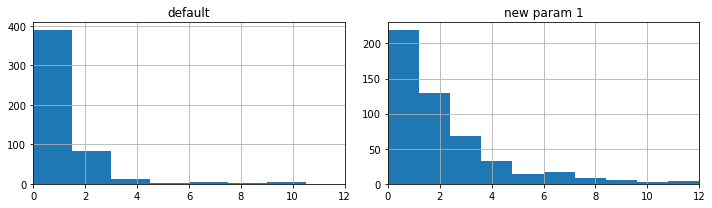

In [93]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax0.hist(data.number_of_steps)
ax0.set_title('default')
ax1.hist(data_par1.number_of_steps)
ax1.set_title('new param 1')
ax0.grid()
ax1.grid()
ax0.set_xlim(0, 12)
ax1.set_xlim(0, 12)
fig.tight_layout()
plt.show()

In [147]:
data_1 = data[data.number_of_steps == 1]
data_5 = data[data.number_of_steps == 5]
mol = [Chem.MolFromSmiles(m) for m in data_1.target]
mol5 = [Chem.MolFromSmiles(m) for m in data_5.target]
data_1 = data_1.assign(mol=mol)
data_5 = data_5.assign(mol=mol5)

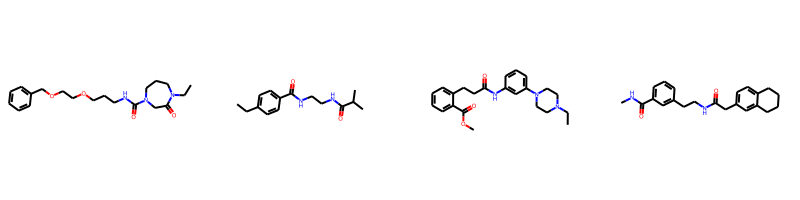

In [150]:
Draw.MolsToGridImage(data_1['mol'], molsPerRow=4, maxMols=4)

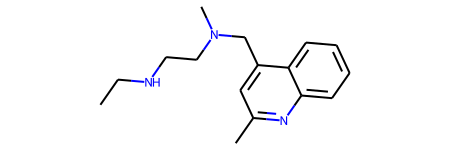

In [152]:
data_1['mol'].iloc[5]

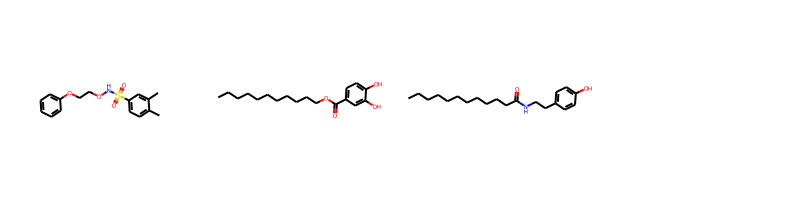

In [11]:
Draw.MolsToGridImage(data_5['mol'], molsPerRow=4, maxMols=4)

# 2,3

In [100]:
data1 = pd.read_csv('data/7Msmiles500-1-default.csv')
data1_par1 = pd.read_csv('data/7Msmiles500-1-par1.csv')

In [117]:
true = len(data1[data1.number_of_steps == 2]) + len(data1[data1.number_of_steps == 3]) 
true1 = len(data1_par1[data1_par1.number_of_steps == 2]) + len(data1_par1[data1_par1.number_of_steps == 3]) 
print("Default ", true/(len(data1)/100), end="% \n")
print("Param 1 ", true1/(len(data1_par1)/100), end="% ")

Default  28.8% 
Param 1  37.6% 

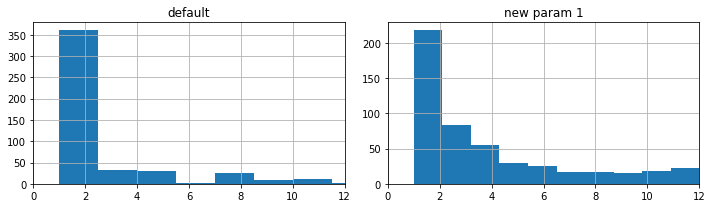

In [118]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax0.hist(data1.number_of_steps)
ax0.set_title('default')
ax1.hist(data1_par1.number_of_steps)
ax1.set_title('new param 1')
ax0.grid()
ax1.grid()
ax0.set_xlim(0, 12)
ax1.set_xlim(0, 12)
fig.tight_layout()
plt.show()

In [31]:
scscore1 = [sc.get_score_from_smi(smile)[1] for smile in data1.target]
syba1 = [sy.predict(smile) for smile in data1.target]
sascore1 = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in data1.target]
data1 = data1.assign(scscore=scscore1, syba=syba1, sascore=sascore1)

In [32]:
data1['hit']='-'
data1.loc[data1['number_of_steps'] == 2, 'hit'] = 'hit'
data1.loc[data1['number_of_steps'] == 3, 'hit'] = 'hit'

[Text(0.5, 0, 'sascore'), Text(0, 0.5, 'scscore')]

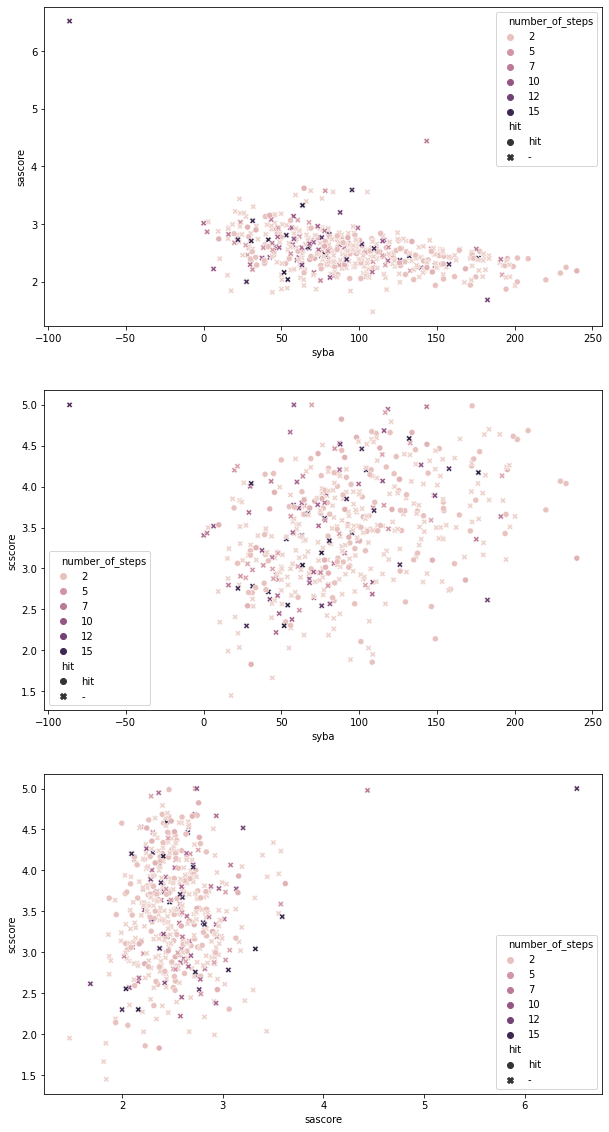

In [33]:
#plt.figure(figsize=(7,7))
fig, axs = plt.subplots(nrows=3,figsize=(10,20))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(data=data1, x="syba", y="sascore", hue="number_of_steps", style="hit", ax=axs[0])
sns.scatterplot(data=data1, x="syba", y="scscore", hue="number_of_steps", style="hit", ax=axs[1])
sns.scatterplot(data=data1, x="sascore", y="scscore", hue="number_of_steps", style="hit", ax=axs[2])
axs[0].set(xlabel="syba", ylabel = "sascore")
axs[1].set(xlabel="syba", ylabel = "scscore")
axs[2].set(xlabel="sascore", ylabel = "scscore")

# 4, 5, 6

In [101]:
data2 = pd.read_csv('data/7Msmiles500-2-default.csv')
data2_par1 = pd.read_csv('data/7Msmiles500-2-par1.csv')
par2 = pd.read_csv('data/7Msmiles500-2-par2.csv')
par3 = pd.read_csv('data/7Msmiles500-2-par3.csv')

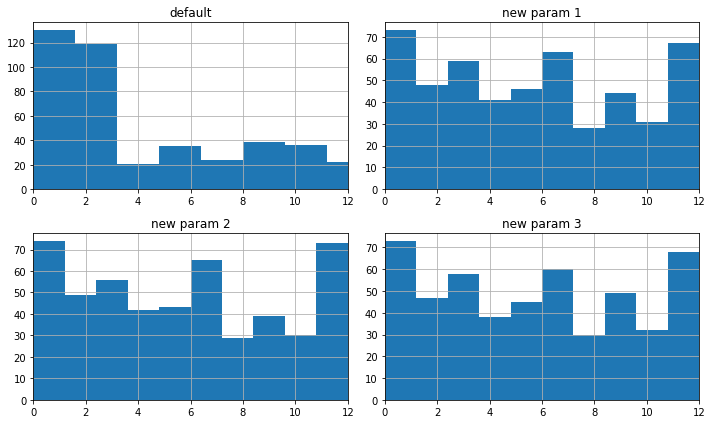

In [95]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax0.hist(data2.number_of_steps)
ax0.set_title('default')
ax1.hist(data2_par1.number_of_steps)
ax1.set_title('new param 1')
ax2.hist(par2.number_of_steps)
ax2.set_title('new param 2')
ax3.hist(par3.number_of_steps)
ax3.set_title('new param 3')
ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax0.set_xlim(0, 12)
ax1.set_xlim(0, 12)
ax2.set_xlim(0, 12)
ax3.set_xlim(0, 12)
fig.tight_layout()
plt.show()

In [85]:
true = len(data2[data2.number_of_steps == 4]) + len(data2[data2.number_of_steps == 5]) + len(data2[data2.number_of_steps == 6])
true1 = len(par1[par1.number_of_steps == 4]) + len(par1[par1.number_of_steps == 5]) + len(par1[par1.number_of_steps == 6])
true2 = len(par2[par2.number_of_steps == 4]) + len(par2[par2.number_of_steps == 5]) + len(par2[par2.number_of_steps == 6])
true3 = len(par3[par3.number_of_steps == 4]) + len(par3[par3.number_of_steps == 5]) + len(par3[par3.number_of_steps == 6])
print("Default ", true/(len(defa)/100), end="% \n")
print("Param 1 ", true1/(len(par1)/100), end="% \n")
print("Param 2 ", true2/(len(par2)/100), end="% \n")
print("Param 3 ", true3/(len(par3)/100), end="% \n")

Default  11.2% 
Param 1  22.8% 
Param 2  21.6% 
Param 3  21.2% 


In [100]:
data2 = par1

# 7 and more

In [153]:
data3 = pd.read_csv('data/7Msmiles500-3-default.csv')
data3_par1 = pd.read_csv('data/7Msmiles500-3-par1.csv')

In [175]:
print("Default: 7 and more: ", len(data3[data3.number_of_steps > 6])/(len(data3)/100), end="% \n")
print("Param 1: 7 and more: ", len(data3_par1[data3_par1.number_of_steps > 6])/(len(data3_par1)/100), end="% ")

Default: 7 and more:  63.2% 
Param 1: 7 and more:  64.2% 

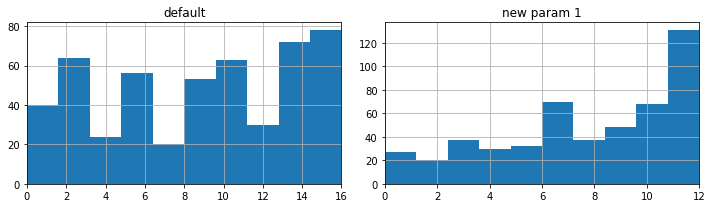

In [176]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax0.hist(data3.number_of_steps)
ax0.set_title('default')
ax1.hist(data3_par1.number_of_steps)
ax1.set_title('new param 1')
ax0.grid()
ax1.grid()
ax0.set_xlim(0, 16)
ax1.set_xlim(0, 12)
fig.tight_layout()
plt.show()

In [155]:
data_10_3 = data3[data3.number_of_steps > 10]
mol103 = [Chem.MolFromSmiles(m) for m in data_10_3.target]
data_10_3 = data_10_3.assign(mol=mol103)

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 16. Change the maxMols value to display more.
  warnings.warn(


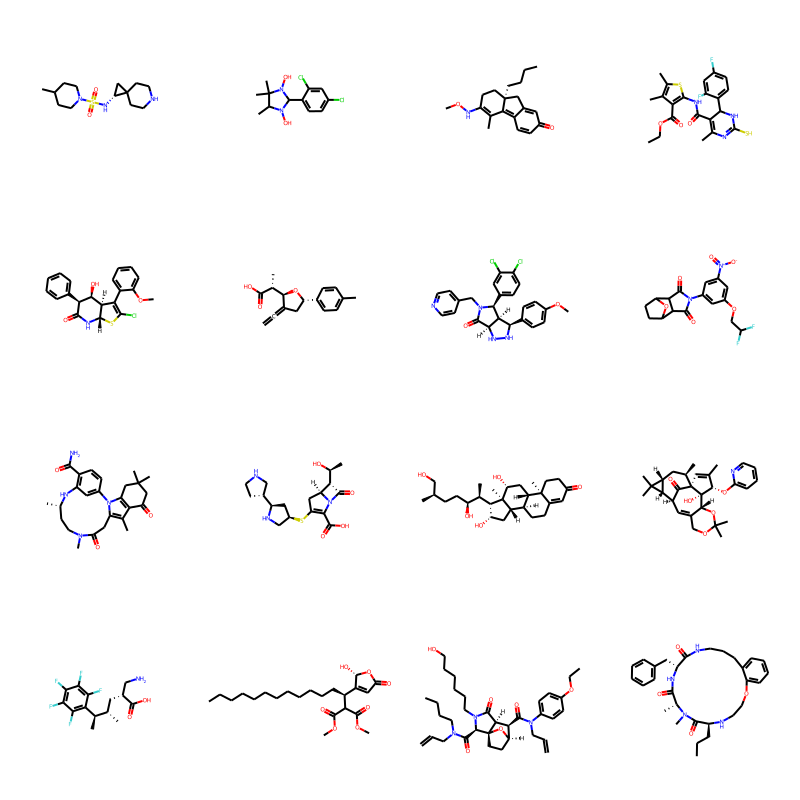

In [30]:
Draw.MolsToGridImage(data_10_3['mol'], molsPerRow=4, maxMols=16)

,mol
0,
3,
7,
8,
9,
10,
15,
16,
20,
21,

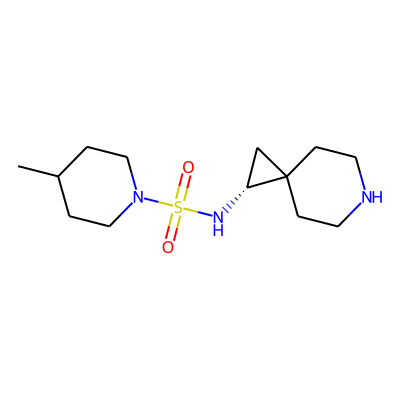
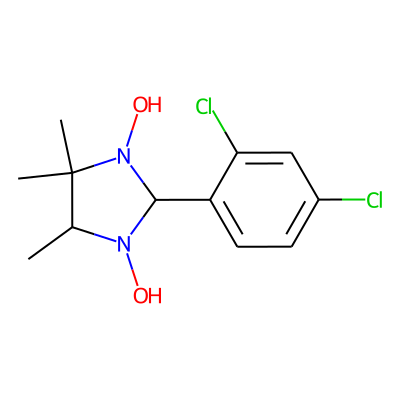
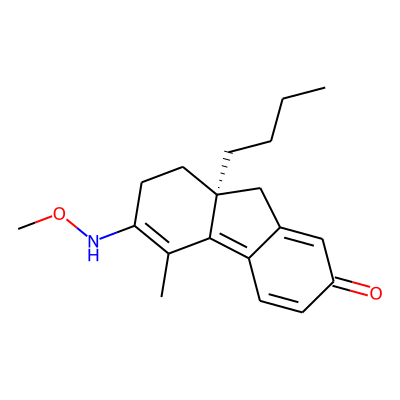
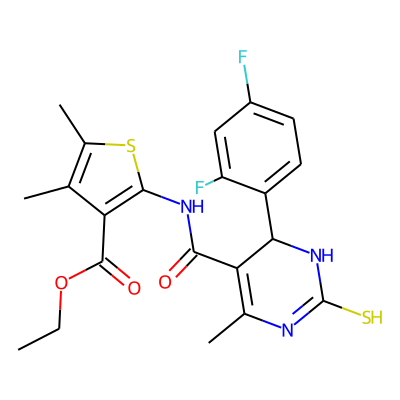
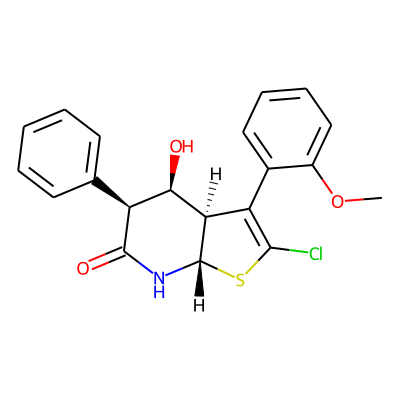
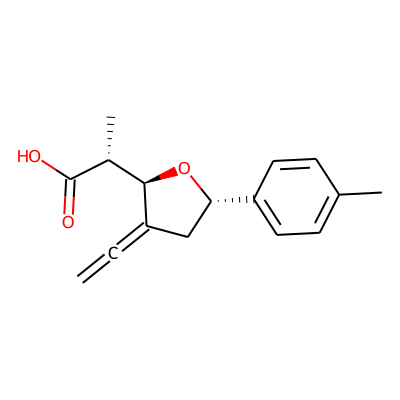
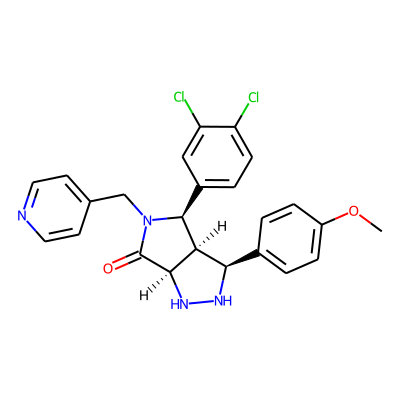
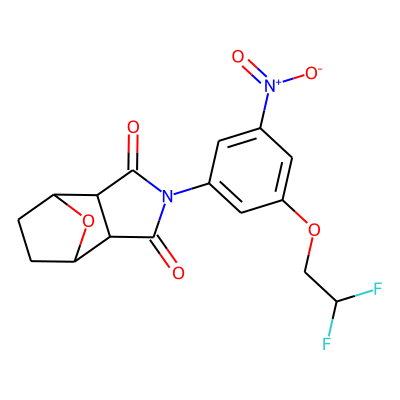
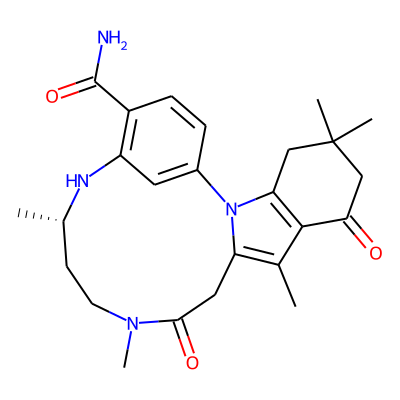
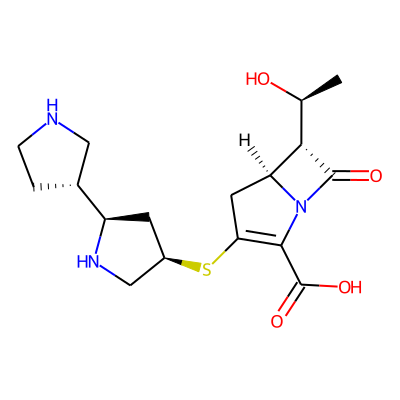
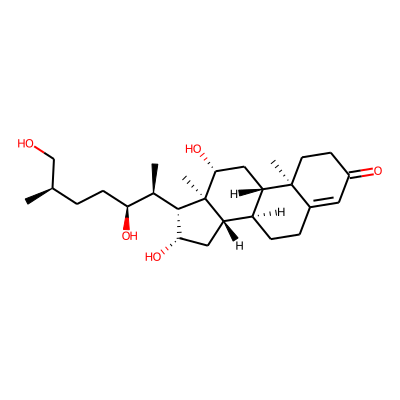
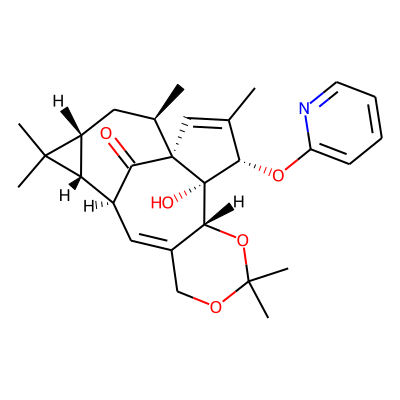
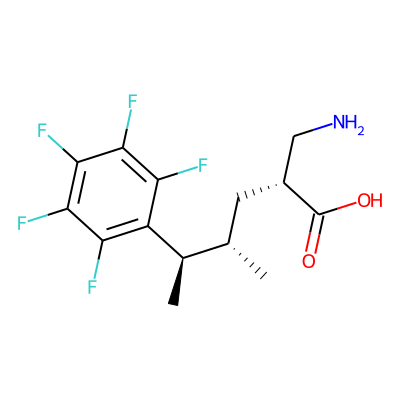
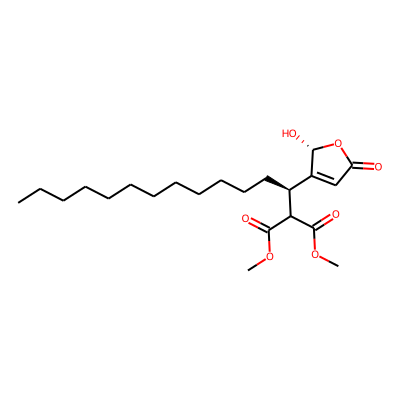
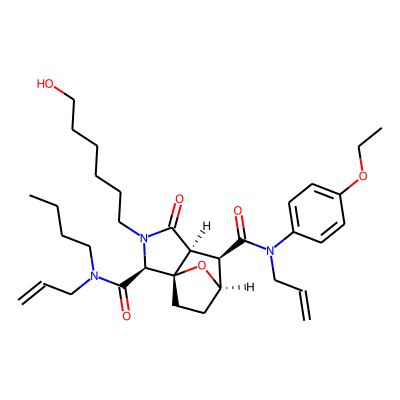

In [163]:
a = data_10_3
HTML(a[['mol']].head(15).to_html(formatters={'mol': mol_display,'mol': mol_display}, escape=False))

# All data

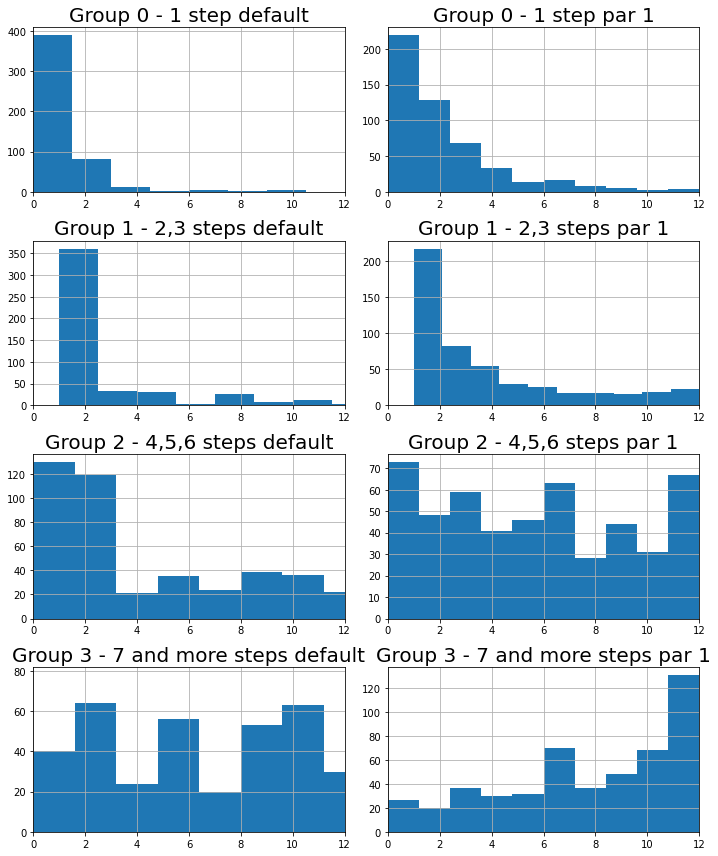

In [103]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(10,12))

ax0.hist(data.number_of_steps)
ax0.set_title('Group 0 - 1 step default')
ax1.hist(data_par1.number_of_steps)
ax1.set_title('Group 0 - 1 step par 1')
ax2.hist(data1.number_of_steps)
ax2.set_title('Group 1 - 2,3 steps default')
ax3.hist(data1_par1.number_of_steps)
ax3.set_title('Group 1 - 2,3 steps par 1')
ax4.hist(data2.number_of_steps)
ax4.set_title('Group 2 - 4,5,6 steps default')
ax5.hist(data2_par1.number_of_steps)
ax5.set_title('Group 2 - 4,5,6 steps par 1')
ax6.hist(data3.number_of_steps)
ax6.set_title('Group 3 - 7 and more steps default')
ax7.hist(data3_par1.number_of_steps)
ax7.set_title('Group 3 - 7 and more steps par 1')

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax0.set_xlim(0, 12)
ax1.set_xlim(0, 12)
ax2.set_xlim(0, 12)
ax3.set_xlim(0, 12)
ax4.set_xlim(0, 12)
ax5.set_xlim(0, 12)
ax6.set_xlim(0, 12)
ax7.set_xlim(0, 12)
fig.tight_layout()
plt.show()

In [111]:
frames = [data_par1, data1_par1, data2_par1, data3_par1]
all_data = pd.concat(frames)
all_data = all_data.reset_index(drop=True)

In [7]:
len(all_data)

2000

<AxesSubplot:>

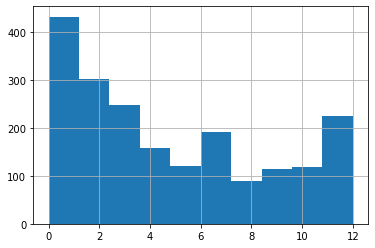

In [8]:
all_data.number_of_steps.hist() 

In [147]:
all_data.number_of_steps.value_counts()

1     427
2     302
3     247
4     159
11    130
5     121
10    119
9     114
7     101
12     94
6      91
8      90
0       5
Name: number_of_steps, dtype: int64

In [137]:
scsc = [sc.get_score_from_smi(smile)[1] for smile in all_data.target]
syba = [sy.predict(smile) for smile in all_data.target]
sasc = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in all_data.target]
all_data = all_data.assign(scscore=scsc, syba=syba, sascore=sasc)

In [112]:
all_data['steps_bins'] = pd.cut(all_data['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) #, labels=False
all_data.steps_bins.value_counts()

1    549
0    427
3    424
2    371
Name: steps_bins, dtype: int64

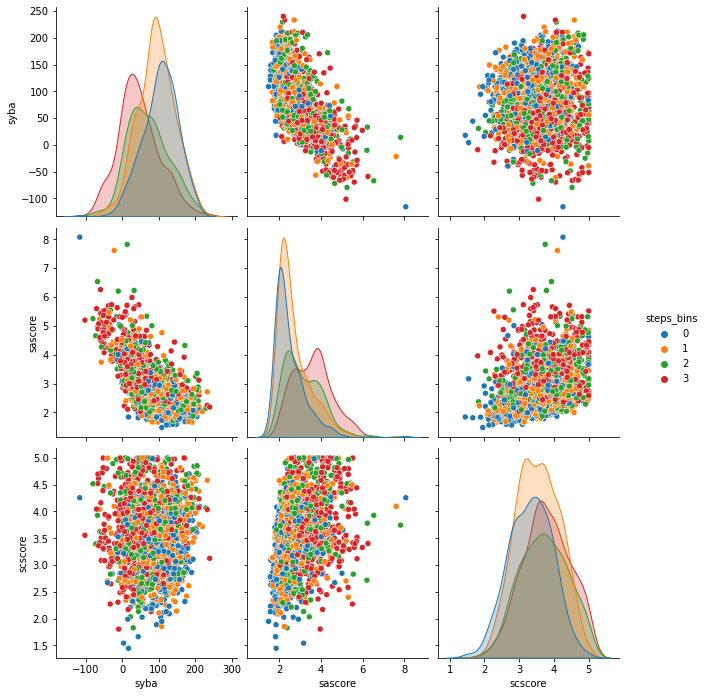

In [139]:
g = sns.pairplot(all_data[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins')
g.fig.set_size_inches(10,10)

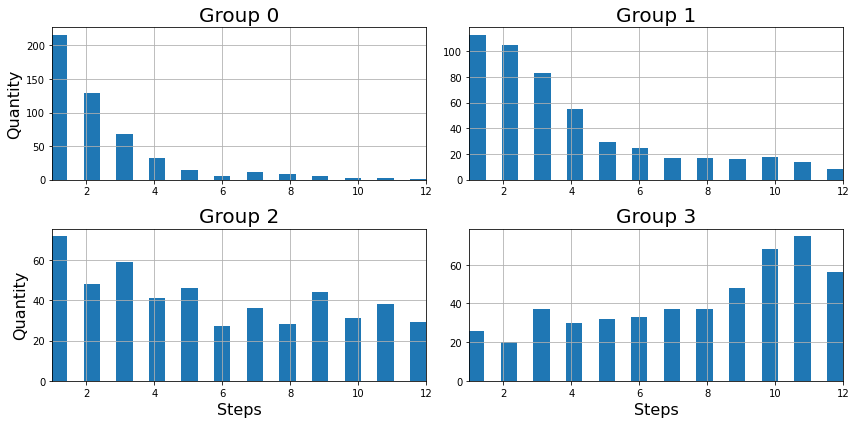

In [109]:
params = {'axes.labelsize': 16, 'axes.titlesize': 20}
plt.rcParams.update(params)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

ax0.hist(data_par1.number_of_steps, bins = 25)
ax0.set_title('Group 0')
ax1.hist(data1_par1.number_of_steps, bins = 23)
ax1.set_title('Group 1')
ax2.hist(data2_par1.number_of_steps, bins = 25)
ax2.set_title('Group 2')
ax3.hist(data3_par1.number_of_steps, bins = 25)
ax3.set_title('Group 3')

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax0.set_xlim(1, 12)
ax1.set_xlim(1, 12)
ax2.set_xlim(1, 12)
ax3.set_xlim(1, 12)
ax3.set_xlabel('Steps')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Quantity')
ax0.set_ylabel('Quantity')
fig.tight_layout()
plt.show()

In [110]:
fig.savefig('distributions.png')

# Balanced representation

In [113]:
data = pd.read_csv('data/7Msmiles500-0-par1.csv')
data1 = pd.read_csv('data/7Msmiles500-1-par1.csv')
data2 = pd.read_csv('data/7Msmiles500-2-par1.csv')
data3 = pd.read_csv('data/7Msmiles500-3-par1.csv')

In [114]:
len(data1), len(data2), len(data3), len(data)

(500, 500, 500, 500)

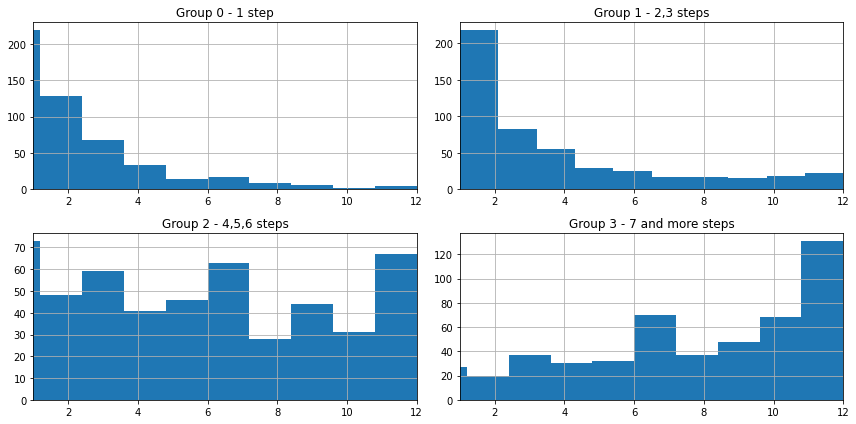

In [11]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
ax0.hist(data.number_of_steps)
ax0.set_title('Group 0 - 1 step')
ax1.hist(data1.number_of_steps)
ax1.set_title('Group 1 - 2,3 steps')
ax2.hist(data2.number_of_steps)
ax2.set_title('Group 2 - 4,5,6 steps')
ax3.hist(data3.number_of_steps)
ax3.set_title('Group 3 - 7 and more steps')
ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax0.set_xlim(1, 12)
ax1.set_xlim(1, 12)
ax2.set_xlim(1, 12)
ax3.set_xlim(1, 12)
fig.tight_layout()
plt.show()

In [115]:
frames = [data1, data2, data3]
all_data1 = pd.concat(frames)
all_data1 = all_data1.reset_index(drop=True)

In [10]:
len(all_data1)

1500

In [116]:
data2 = pd.read_csv('data/7Msmiles1500-2-par1.csv')
frames = [data1, data2, data3]
all_data2 = pd.concat(frames)
all_data2 = all_data2.reset_index(drop=True)

In [117]:
data1 = pd.read_csv('data/7Msmiles500-1-par1.csv')
data2 = pd.read_csv('data/7Msmiles500-2-par1.csv')
data3 = pd.read_csv('data/7Msmiles1500-3-par1.csv')
frames = [data1, data2, data3]
all_data3 = pd.concat(frames)
all_data3 = all_data3.reset_index(drop=True)

In [118]:
data2 = pd.read_csv('data/7Msmiles500-2-par1.csv')
data3 = pd.read_csv('data/7Msmiles1500-3-par1.csv')
frames = [data2, data3]
all_data4 = pd.concat(frames)
all_data4 = all_data4.reset_index(drop=True)

In [119]:
data3 = pd.read_csv('data/7Msmiles1500-3-par1.csv')
data2 = pd.read_csv('data/7Msmiles1500-2-par1.csv')
frames = [data2, data3]
all_data5 = pd.concat(frames)
all_data5 = all_data5.reset_index(drop=True)

In [120]:
#data2 = pd.read_csv('data/7Msmiles1500-2-par1.csv')
#data3 = pd.read_csv('data/7Msmiles1500-3-par1.csv')
#frames = [data2, data3]
#all_data6 = pd.concat(frames)
#all_data6 = all_data6.reset_index(drop=True)

In [110]:
#all_data6['steps_bins'] = pd.cut(all_data6['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) #, labels=False 
#all_data6.steps_bins.value_counts()

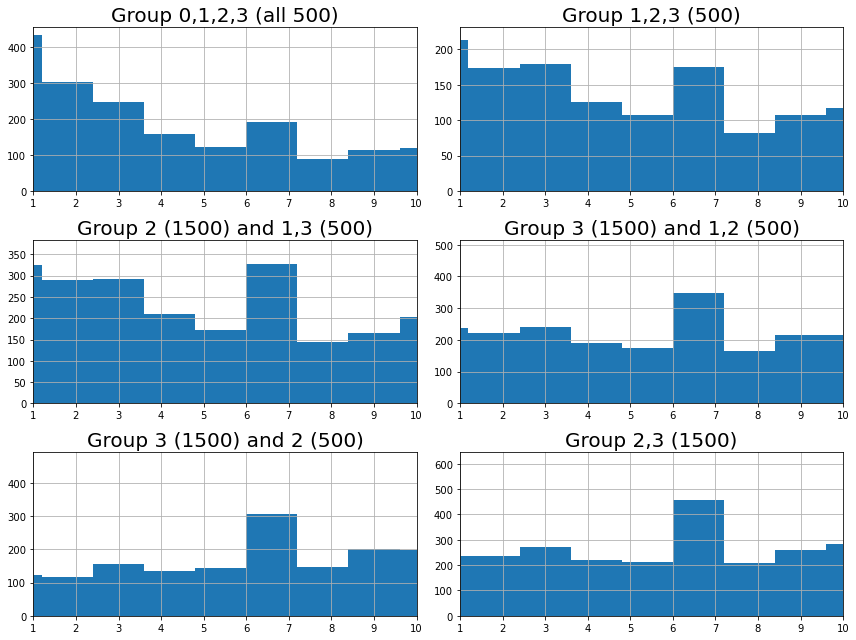

In [18]:
params = {'axes.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(params)
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(12,9))
ax0.hist(all_data.number_of_steps)
ax0.set_title('Group 0,1,2,3 (all 500)')
ax1.hist(all_data1.number_of_steps)
ax1.set_title('Group 1,2,3 (500)')
ax2.hist(all_data2.number_of_steps)
ax2.set_title('Group 2 (1500) and 1,3 (500)')
ax3.hist(all_data3.number_of_steps)
ax3.set_title('Group 3 (1500) and 1,2 (500)')
ax4.hist(all_data4.number_of_steps)
ax4.set_title('Group 3 (1500) and 2 (500)')
ax5.hist(all_data5.number_of_steps)
ax5.set_title('Group 2,3 (1500)')
ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax0.set_xlim(1, 10)
ax1.set_xlim(1, 10)
ax2.set_xlim(1, 10)
ax3.set_xlim(1, 10)
ax4.set_xlim(1, 10)
ax5.set_xlim(1, 10)
fig.tight_layout()
plt.show()

In [121]:
all_data = all_data[all_data.number_of_steps <= 10]
all_data = all_data[all_data.number_of_steps > 0]
count_0 = all_data.number_of_steps.value_counts()
df_count_0 = pd.DataFrame(count_0)

all_data1 = all_data1[all_data1.number_of_steps <= 10]
all_data1 = all_data1[all_data1.number_of_steps > 0]
count_1 = all_data1.number_of_steps.value_counts()
df_count_1 = pd.DataFrame(count_1)

all_data2 = all_data2[all_data2.number_of_steps <= 10]
all_data2 = all_data2[all_data2.number_of_steps > 0]
count_2 = all_data2.number_of_steps.value_counts()
df_count_2 = pd.DataFrame(count_2)

all_data3 = all_data3[all_data3.number_of_steps <= 10]
all_data3 = all_data3[all_data3.number_of_steps > 0]
count_3 = all_data3.number_of_steps.value_counts()
df_count_3 = pd.DataFrame(count_3)

all_data4 = all_data4[all_data4.number_of_steps <= 10]
all_data4 = all_data4[all_data4.number_of_steps > 0]
count_4 = all_data4.number_of_steps.value_counts()
df_count_4 = pd.DataFrame(count_4)

all_data5 = all_data5[all_data5.number_of_steps <= 10]
all_data5 = all_data5[all_data5.number_of_steps > 0]
count_5 = all_data5.number_of_steps.value_counts()
df_count_5 = pd.DataFrame(count_5)

In [23]:
display_in_matrix_form(df_count_0, df_count_1, df_count_2, df_count_3, df_count_4, df_count_5, 
                       titles=['0,1,2,3 (500)','1,2,3 (500)','2 (1500) 1,3 (500)',
                               '3 (1500) 1,2 (500)','3 (1500) 2 (500)','2,3 (1500)'], 
                       rows = 2, columns = 3) 

,number_of_steps
1,427
2,302
3,247
4,159
5,121
10,119
9,114
7,101
6,91
8,90


,number_of_steps
3,240
1,234
2,223
9,217
10,216
4,190
7,190
5,174
8,164
6,158


In [21]:
print("0,1,2,3 (500):       ", df_count_0.number_of_steps.iloc[0] - df_count_0.number_of_steps.iloc[-1])
print("1,2,3 (500):         ", df_count_1.number_of_steps.iloc[0] - df_count_1.number_of_steps.iloc[-1])
print("2 (1500) 1,3 (500):  ", df_count_2.number_of_steps.iloc[0] - df_count_2.number_of_steps.iloc[-1])
print("3 (1500) 1,2 (500):  ", df_count_3.number_of_steps.iloc[0] - df_count_3.number_of_steps.iloc[-1])
print("3 (1500) 2 (500):    ", df_count_4.number_of_steps.iloc[0] - df_count_4.number_of_steps.iloc[-1])
print("2,3 (1500):          ", df_count_5.number_of_steps.iloc[0] - df_count_5.number_of_steps.iloc[-1])

0,1,2,3 (500):        337
1,2,3 (500):          129
2 (1500) 1,3 (500):   178
3 (1500) 1,2 (500):   82
3 (1500) 2 (500):     83
2,3 (1500):           77


In [125]:
all_data['steps_bins'] = pd.cut(all_data['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) #, labels=False
all_data1['steps_bins'] = pd.cut(all_data1['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) #, labels=False 
all_data2['steps_bins'] = pd.cut(all_data2['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3])
all_data3['steps_bins'] = pd.cut(all_data3['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) 
all_data4['steps_bins'] = pd.cut(all_data4['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) 
all_data5['steps_bins'] = pd.cut(all_data5['number_of_steps'], [0,1,3,6,10], labels=[0,1,2,3]) 

In [126]:
count_0 = all_data.steps_bins.value_counts()
df_count_0 = pd.DataFrame(count_0)
count_1 = all_data1.steps_bins.value_counts()
df_count_1 = pd.DataFrame(count_1)
count_2 = all_data2.steps_bins.value_counts()
df_count_2 = pd.DataFrame(count_2)
count_3 = all_data3.steps_bins.value_counts()
df_count_3 = pd.DataFrame(count_3)
count_4 = all_data4.steps_bins.value_counts()
df_count_4 = pd.DataFrame(count_4)
count_5 = all_data5.steps_bins.value_counts()
df_count_5 = pd.DataFrame(count_5)

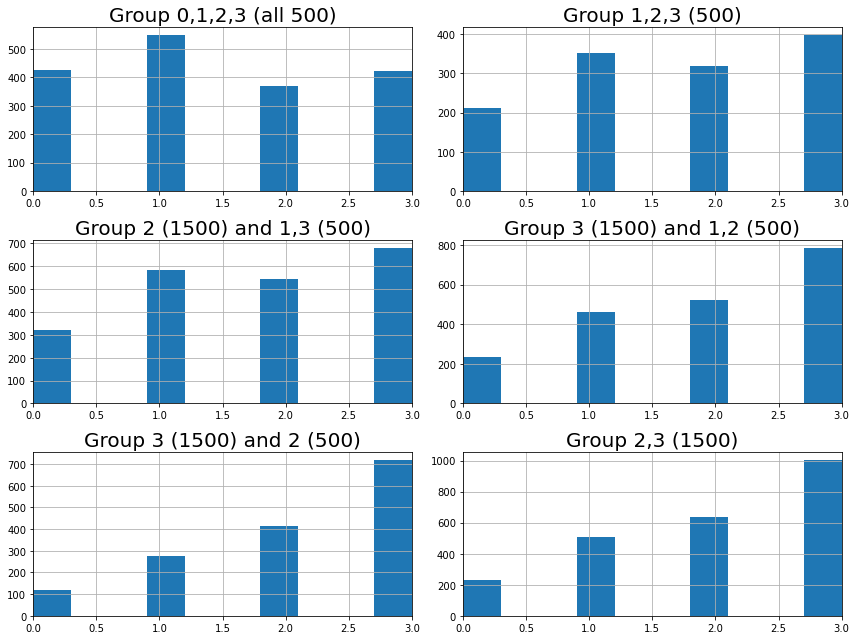

In [27]:
params = {'axes.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(params)
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(12,9))
ax0.hist(all_data.steps_bins)
ax0.set_title('Group 0,1,2,3 (all 500)')
ax1.hist(all_data1.steps_bins)
ax1.set_title('Group 1,2,3 (500)')
ax2.hist(all_data2.steps_bins)
ax2.set_title('Group 2 (1500) and 1,3 (500)')
ax3.hist(all_data3.steps_bins)
ax3.set_title('Group 3 (1500) and 1,2 (500)')
ax4.hist(all_data4.steps_bins)
ax4.set_title('Group 3 (1500) and 2 (500)')
ax5.hist(all_data5.steps_bins)
ax5.set_title('Group 2,3 (1500)')
ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax0.set_xlim(0, 3)
ax1.set_xlim(0, 3)
ax2.set_xlim(0, 3)
ax3.set_xlim(0, 3)
ax4.set_xlim(0, 3)
ax5.set_xlim(0, 3)
fig.tight_layout()
plt.show()

In [28]:
display_in_matrix_form(df_count_0, df_count_1, df_count_2, df_count_3, df_count_4, df_count_5, 
                       titles=['0,1,2,3 (500)','1,2,3 (500)','2 (1500) 1,3 (500)',
                               '3 (1500) 1,2 (500)','3 (1500) 2 (500)','2,3 (1500)'], 
                       rows = 2, columns = 3) 

,steps_bins
1,549
0,427
3,424
2,371
,steps_bins
3,397
1,352
2,318
0,211
,steps_bins


,steps_bins
3,787
2,522
1,463
0,234
,steps_bins
3,719
2,413
1,275
0,121
,steps_bins


In [30]:
print("0,1,2,3 (500):       ", df_count_0.steps_bins.iloc[0] - df_count_0.steps_bins.iloc[-1])
print("1,2,3 (500):         ", df_count_1.steps_bins.iloc[0] - df_count_1.steps_bins.iloc[-1])
print("2 (1500) 1,3 (500):  ", df_count_2.steps_bins.iloc[0] - df_count_2.steps_bins.iloc[-1])
print("3 (1500) 1,2 (500):  ", df_count_3.steps_bins.iloc[0] - df_count_3.steps_bins.iloc[-1])
print("3 (1500) 2 (500):    ", df_count_4.steps_bins.iloc[0] - df_count_4.steps_bins.iloc[-1])
print("2,3 (1500):          ", df_count_5.steps_bins.iloc[0] - df_count_5.steps_bins.iloc[-1])

0,1,2,3 (500):        178
1,2,3 (500):          186
2 (1500) 1,3 (500):   359
3 (1500) 1,2 (500):   553
3 (1500) 2 (500):     598
2,3 (1500):           771


In [127]:
all_data = all_data[all_data.number_of_steps > 0]
all_data = all_data[all_data.number_of_steps < 11]
all_data3 = all_data3[all_data3.number_of_steps > 0]
all_data3 = all_data3[all_data3.number_of_steps < 11]
all_data5 = all_data5[all_data5.number_of_steps > 0]
all_data5 = all_data5[all_data5.number_of_steps < 11]

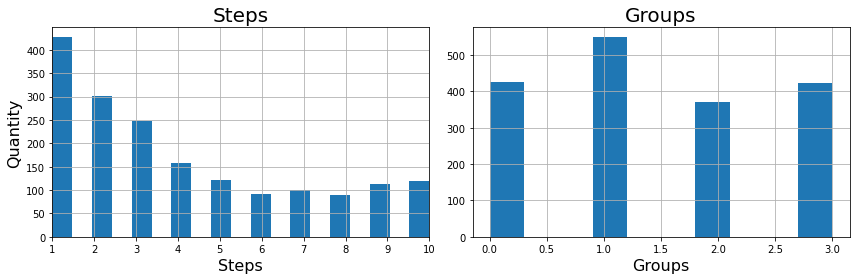

In [140]:
params = {'axes.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(params)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax0.hist(all_data.number_of_steps,bins = 19)
ax0.set_title('Steps')
ax1.hist(all_data.steps_bins)
ax1.set_title('Groups')
ax0.grid()
ax1.grid()
ax0.set_xlim(1, 10)
ax2.set_xlim(1, 10)
ax0.set_xlabel('Steps')
ax1.set_xlabel('Groups')
ax0.set_ylabel('Quantity')
#ax1.set_ylabel('Quantity')
fig.tight_layout()
plt.show()

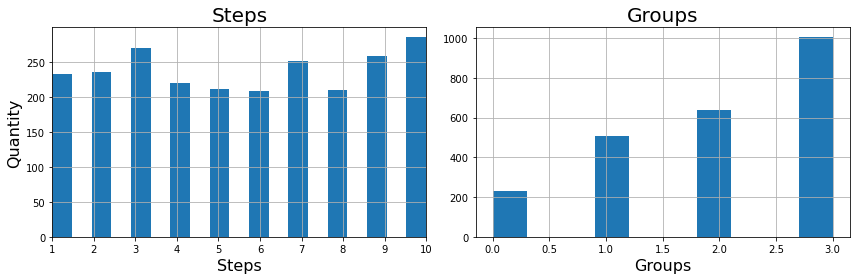

In [142]:
params = {'axes.labelsize': 16,'axes.titlesize': 20}
plt.rcParams.update(params)
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax0.hist(all_data5.number_of_steps,bins = 19)
ax0.set_title('Steps')
ax1.hist(all_data5.steps_bins)
ax1.set_title('Groups')
ax0.grid()
ax1.grid()
ax0.set_xlim(1, 10)
ax0.set_xlabel('Steps')
ax1.set_xlabel('Groups')
ax0.set_ylabel('Quantity')
fig.tight_layout()
plt.show()

In [143]:
fig.savefig('distributions with bins2.png')